**Predicting Traffic Volume**
|
Data source: https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume

In [74]:
import pandas as pd
import numpy as np
import datetime
import os
import mylib as my

from sklearn.linear_model import LinearRegression

df=pd.read_csv("TRAFFIC_VOLUME.csv")
print(df.shape)
df.head()

(48204, 9)


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,10/2/2012 9:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,10/2/2012 10:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,10/2/2012 11:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,10/2/2012 12:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,10/2/2012 13:00,4918


In [75]:
df.date_time

0         10/2/2012 9:00
1        10/2/2012 10:00
2        10/2/2012 11:00
3        10/2/2012 12:00
4        10/2/2012 13:00
              ...       
48199    9/30/2018 19:00
48200    9/30/2018 20:00
48201    9/30/2018 21:00
48202    9/30/2018 22:00
48203    9/30/2018 23:00
Name: date_time, Length: 48204, dtype: object

**Manipulations of date time data**

From date_time want day of week, time of day in hours since midnight and days since jan 1 of year (day of year)

In [76]:
df["date_time"]=pd.to_datetime(df["date_time"])


df["date"]=df["date_time"].dt.date
df["time"]=df["date_time"].dt.time
df["year"]=df["date"].apply(lambda x:x.year)
df["day1ofyear"]=df["year"].apply(lambda x:datetime.date(x,1,1))
df["dayofyear"]=df["date"]-df["day1ofyear"]
df["dayofyear"]=df["dayofyear"].apply(lambda x:x.days)
df["hour"]=df["time"].apply(lambda x:x.hour+x.minute/60+x.second/3600)
df["weekday"]=df["date"].apply(lambda x:x.weekday())
firstdatetime=min(df["date_time"])
df["day"]=df["date_time"]-firstdatetime
df["day"]=df["day"].apply(lambda x:x.days)

In [77]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,date,time,year,day1ofyear,dayofyear,hour,weekday,day
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545,2012-10-02,09:00:00,2012,2012-01-01,275,9.0,1,0
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516,2012-10-02,10:00:00,2012,2012-01-01,275,10.0,1,0
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767,2012-10-02,11:00:00,2012,2012-01-01,275,11.0,1,0
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026,2012-10-02,12:00:00,2012,2012-01-01,275,12.0,1,0
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918,2012-10-02,13:00:00,2012,2012-01-01,275,13.0,1,0


In [78]:
df.date_time

0       2012-10-02 09:00:00
1       2012-10-02 10:00:00
2       2012-10-02 11:00:00
3       2012-10-02 12:00:00
4       2012-10-02 13:00:00
                ...        
48199   2018-09-30 19:00:00
48200   2018-09-30 20:00:00
48201   2018-09-30 21:00:00
48202   2018-09-30 22:00:00
48203   2018-09-30 23:00:00
Name: date_time, Length: 48204, dtype: datetime64[ns]

**Are data ordered by time?**

We'll need to know the answer for reasons that will be apparent shortly. How can we check ordering of time?

We can difference time (compute successive differences) and check that the time delta (in seconds) is always positive.

In [79]:
df["time_diff"]=df.date_time.diff().dt.seconds
df.time_diff.value_counts()

time_diff
3600.0     37987
0.0         7633
7200.0      2192
10800.0      202
14400.0       59
18000.0       33
21600.0       19
36000.0       14
28800.0       13
32400.0       13
25200.0       10
79200.0        5
39600.0        4
75600.0        4
50400.0        3
46800.0        3
43200.0        2
54000.0        2
61200.0        2
82800.0        1
68400.0        1
64800.0        1
Name: count, dtype: int64

In [80]:
df.to_csv("temp.csv")

**Lots of zeros!!! The dataset contains rows with identical times!!**
**Are those duplicates?**

We want a data frame of all values with a time difference of zero and their predecessors so we can inspect.

Make a list of all rows with time_diff equal to zero and predecessors and inspect.

In [81]:
N=df.shape[0]
keep=[i for i in range(N-1) if df.time_diff[i]==0. or df.time_diff[i+1]==0]
df.loc[keep].to_csv("duplicates.csv")

**Remove all rows that have same date/time as preceding**

And redo the index.

In [82]:
df=df.loc[df.time_diff!=0]
df.index=range(df.shape[0])

In [83]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,date,time,year,day1ofyear,dayofyear,hour,weekday,day,time_diff
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545,2012-10-02,09:00:00,2012,2012-01-01,275,9.0,1,0,NaN
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516,2012-10-02,10:00:00,2012,2012-01-01,275,10.0,1,0,3600.0
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767,2012-10-02,11:00:00,2012,2012-01-01,275,11.0,1,0,3600.0
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026,2012-10-02,12:00:00,2012,2012-01-01,275,12.0,1,0,3600.0
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918,2012-10-02,13:00:00,2012,2012-01-01,275,13.0,1,0,3600.0


**Inspect  some of the variables**

<Axes: >

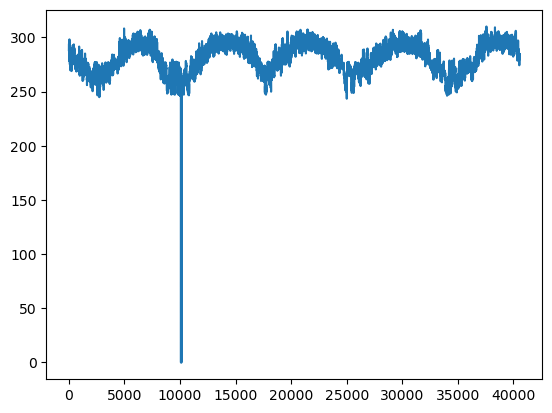

In [84]:
df["temp"].plot()

<Axes: >

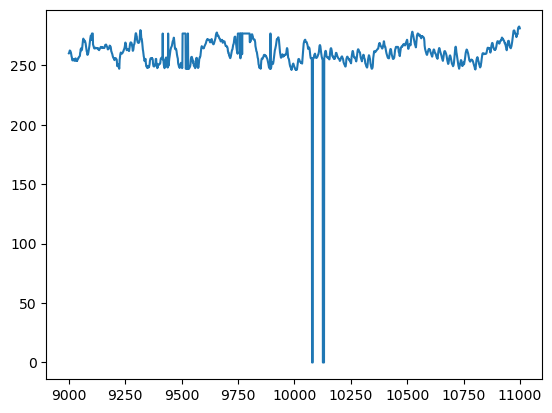

In [85]:
df["temp"].iloc[9000:11000].plot()

**Temperatures are in Kelvin**

We can

- remove rows that appear as outliers
- try to use imputation to replace some entries.

Since temperature is a continuously varying quantity in time, it makes sense to impute.
Here we'll use linear interpolation after changing those outliers to missing.

Before doing that, we should have ensured that the data is ordered with respect to time.

In [86]:
df.loc[df.temp<200,"temp"]=np.nan

**Plotting ignores missing values**

<Axes: >

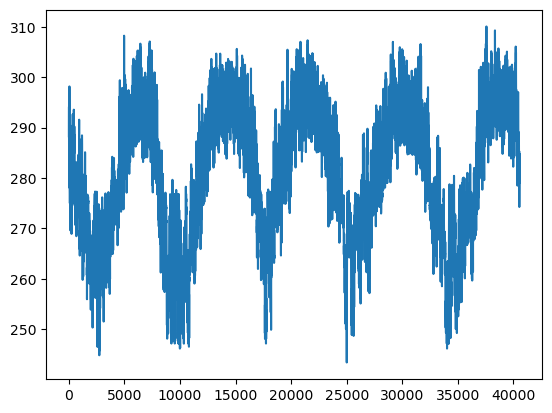

In [87]:
df["temp"].plot()

In [88]:
df["temp"]=df["temp"].interpolate()

In [89]:
df.temp.isna().sum()

0

**Plot amount of rain during the hour**

<Axes: >

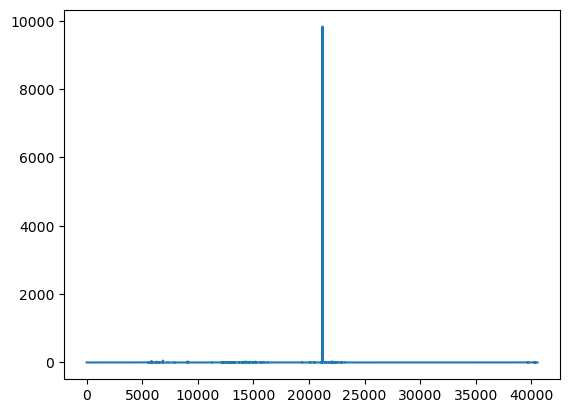

In [90]:
df["rain_1h"].plot()

<Axes: >

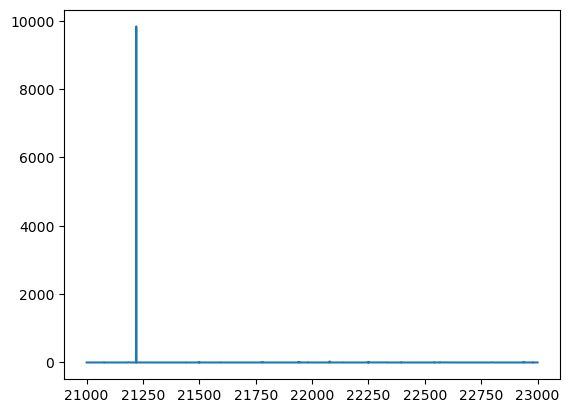

In [91]:
df["rain_1h"].loc[21000:23000].plot()

In [92]:
max(df["rain_1h"])

9831.3

Rain is in mm - 9,831mm would mean around 10m in one hour. Hard to believe!

In [93]:
sum(df["rain_1h"]>1000)

1

In [94]:
df.loc[df.rain_1h>1000,"rain_1h"]=np.nan

<Axes: >

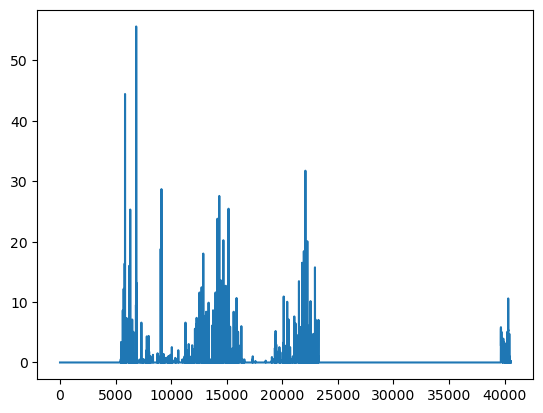

In [95]:
df["rain_1h"]=df.rain_1h.interpolate()
df.rain_1h.plot()

<Axes: >

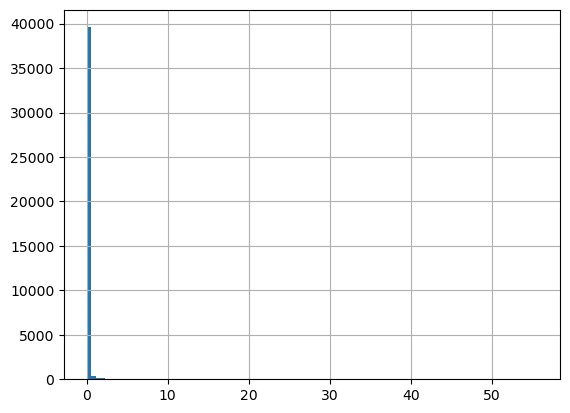

In [96]:
df.rain_1h.hist(bins=100)

This is a heavy-tailed distribution. Create a log rain variable.

In [97]:
df["lrain"]=df["rain_1h"].apply(lambda x:np.log(1.+x))

<Axes: >

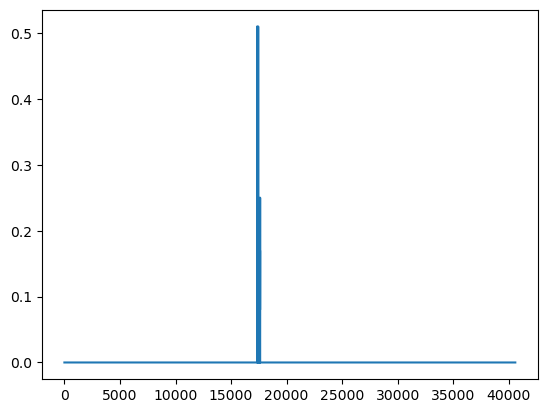

In [98]:
df["snow_1h"].plot()

<Axes: >

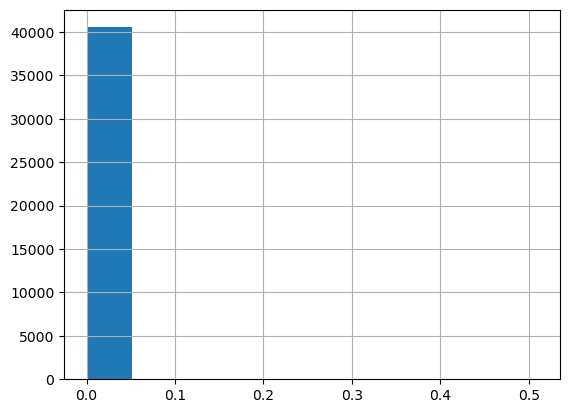

In [99]:
df["snow_1h"].hist()

In [100]:
df["snow_1h"].value_counts()

snow_1h
0.00    40540
0.05        8
0.06        6
0.25        3
0.13        3
0.10        3
0.51        2
0.32        2
0.21        1
0.44        1
0.17        1
0.08        1
Name: count, dtype: int64

Create a snow indicator

In [101]:
df["snowind"]=(df["snow_1h"]>0.).apply(lambda x:int(x))

In [102]:
df["snowind"]=(df["snow_1h"]>0.).astype(int)

In [103]:
df["snowind"].value_counts()

snowind
0    40540
1       31
Name: count, dtype: int64

In [104]:
df["year"].value_counts()

year
2017    8713
2016    7838
2013    7293
2018    6533
2014    4500
2015    3591
2012    2103
Name: count, dtype: int64

In [105]:
df["weekday"].value_counts()

weekday
4    5877
6    5812
2    5802
0    5799
3    5797
5    5782
1    5702
Name: count, dtype: int64

In [106]:
df["hour"].value_counts()

hour
23.0    1739
0.0     1723
22.0    1719
1.0     1710
20.0    1709
16.0    1707
10.0    1705
21.0    1703
4.0     1703
2.0     1697
14.0    1697
12.0    1692
8.0     1689
5.0     1685
19.0    1683
6.0     1683
18.0    1681
13.0    1673
7.0     1672
3.0     1669
11.0    1667
17.0    1664
15.0    1663
9.0     1638
Name: count, dtype: int64

<Axes: >

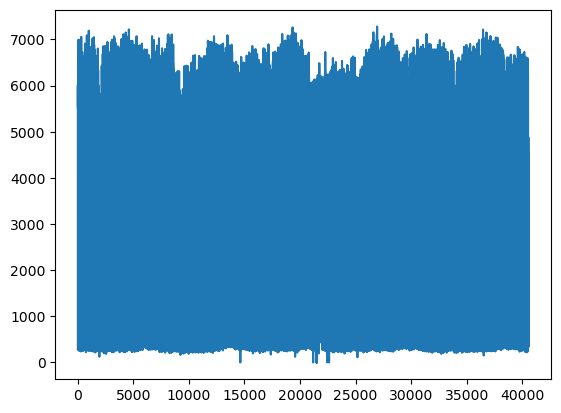

In [107]:
df.loc[0:100000,"traffic_volume"].plot()

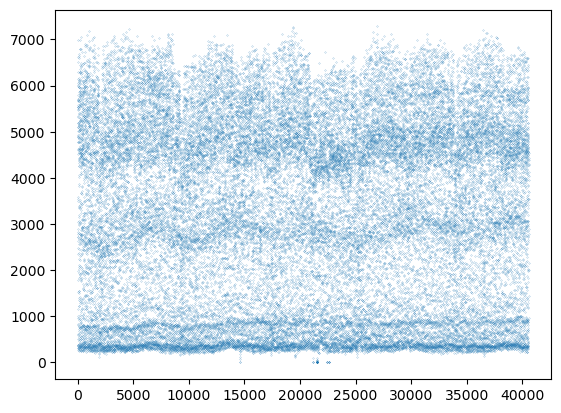

In [108]:
import matplotlib.pyplot as plt
plt.scatter(range(df.shape[0]),df["traffic_volume"],s=.02)

In [109]:
df.holiday.value_counts()

holiday
Columbus Day                 5
Veterans Day                 5
Thanksgiving Day             5
Christmas Day                5
New Years Day                5
Washingtons Birthday         5
Memorial Day                 5
Independence Day             5
State Fair                   5
Labor Day                    5
Martin Luther King Jr Day    3
Name: count, dtype: int64

In [110]:
df["holiday"]

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
40566    NaN
40567    NaN
40568    NaN
40569    NaN
40570    NaN
Name: holiday, Length: 40571, dtype: object

In [111]:
df["holiday"].value_counts()

holiday
Columbus Day                 5
Veterans Day                 5
Thanksgiving Day             5
Christmas Day                5
New Years Day                5
Washingtons Birthday         5
Memorial Day                 5
Independence Day             5
State Fair                   5
Labor Day                    5
Martin Luther King Jr Day    3
Name: count, dtype: int64

In [112]:
df["holiday_ind"]=1-(df["holiday"]=="None")

In [113]:
df["holiday_ind"].value_counts()

holiday_ind
1    40571
Name: count, dtype: int64

In [114]:
df["weather_main"].value_counts(dropna=False)

weather_main
Clouds          15121
Clear           13366
Rain             4767
Mist             3069
Snow             2297
Haze              766
Drizzle           515
Thunderstorm      453
Fog               201
Smoke              15
Squall              1
Name: count, dtype: int64

Some values are rare, so combine some weather types into "Other"

In [115]:
df.loc[df.weather_main=="Smoke","weather_main"]="Other"
df.loc[df.weather_main=="Fog","weather_main"]="Other"
df.loc[df.weather_main=="Squall","weather_main"]="Other"

In [116]:
df["weather_main"].value_counts()

weather_main
Clouds          15121
Clear           13366
Rain             4767
Mist             3069
Snow             2297
Haze              766
Drizzle           515
Thunderstorm      453
Other             217
Name: count, dtype: int64

**Accounting for periodicity with a known period**

From day of year, create two columns sin(2$\pi$day) and cos(2$\pi$day/365)

We do this so that we can allow for a 1 year sinusoidal periodicity in the traffic volume values

Note that any expression of the form

$$A cos(2 \pi \omega t) + B sin(2 \pi \omega t)$$

can be expressed in the form

$$R sin(2 \pi \omega(t - \gamma))$$

for some choice of $\gamma$ (phase) and $R=\sqrt{A^2+B^2}$ and vice versa.

So we can create columns of cosine values and sine values and include in the fitting process.


In [117]:
df["daysin"]=np.sin(2*df["day"]*np.pi/365)
df["daycos"]=np.cos(2*df["day"]*np.pi/365)

To illustrate, let's fit a simple regression model for the temperature column using 
these extra columns. First, to get some intuition, we can get some intuition, we can 
plot an eyeball fit of a model that says:

$temp(t) = \beta_0 + \beta_1 \cos(2 \pi t/365)+ \beta_2 \sin(2 \pi t/365)$

Extract some columns and create a numpy array out of them.

In [118]:
dftemp=df.loc[:,["day","daysin","daycos","temp"]].values # note values allows conversion to numpy array
dftemp.shape

(40571, 4)

To illustrate what we'd like to see, plot one of those functions for some choice of the parameters.

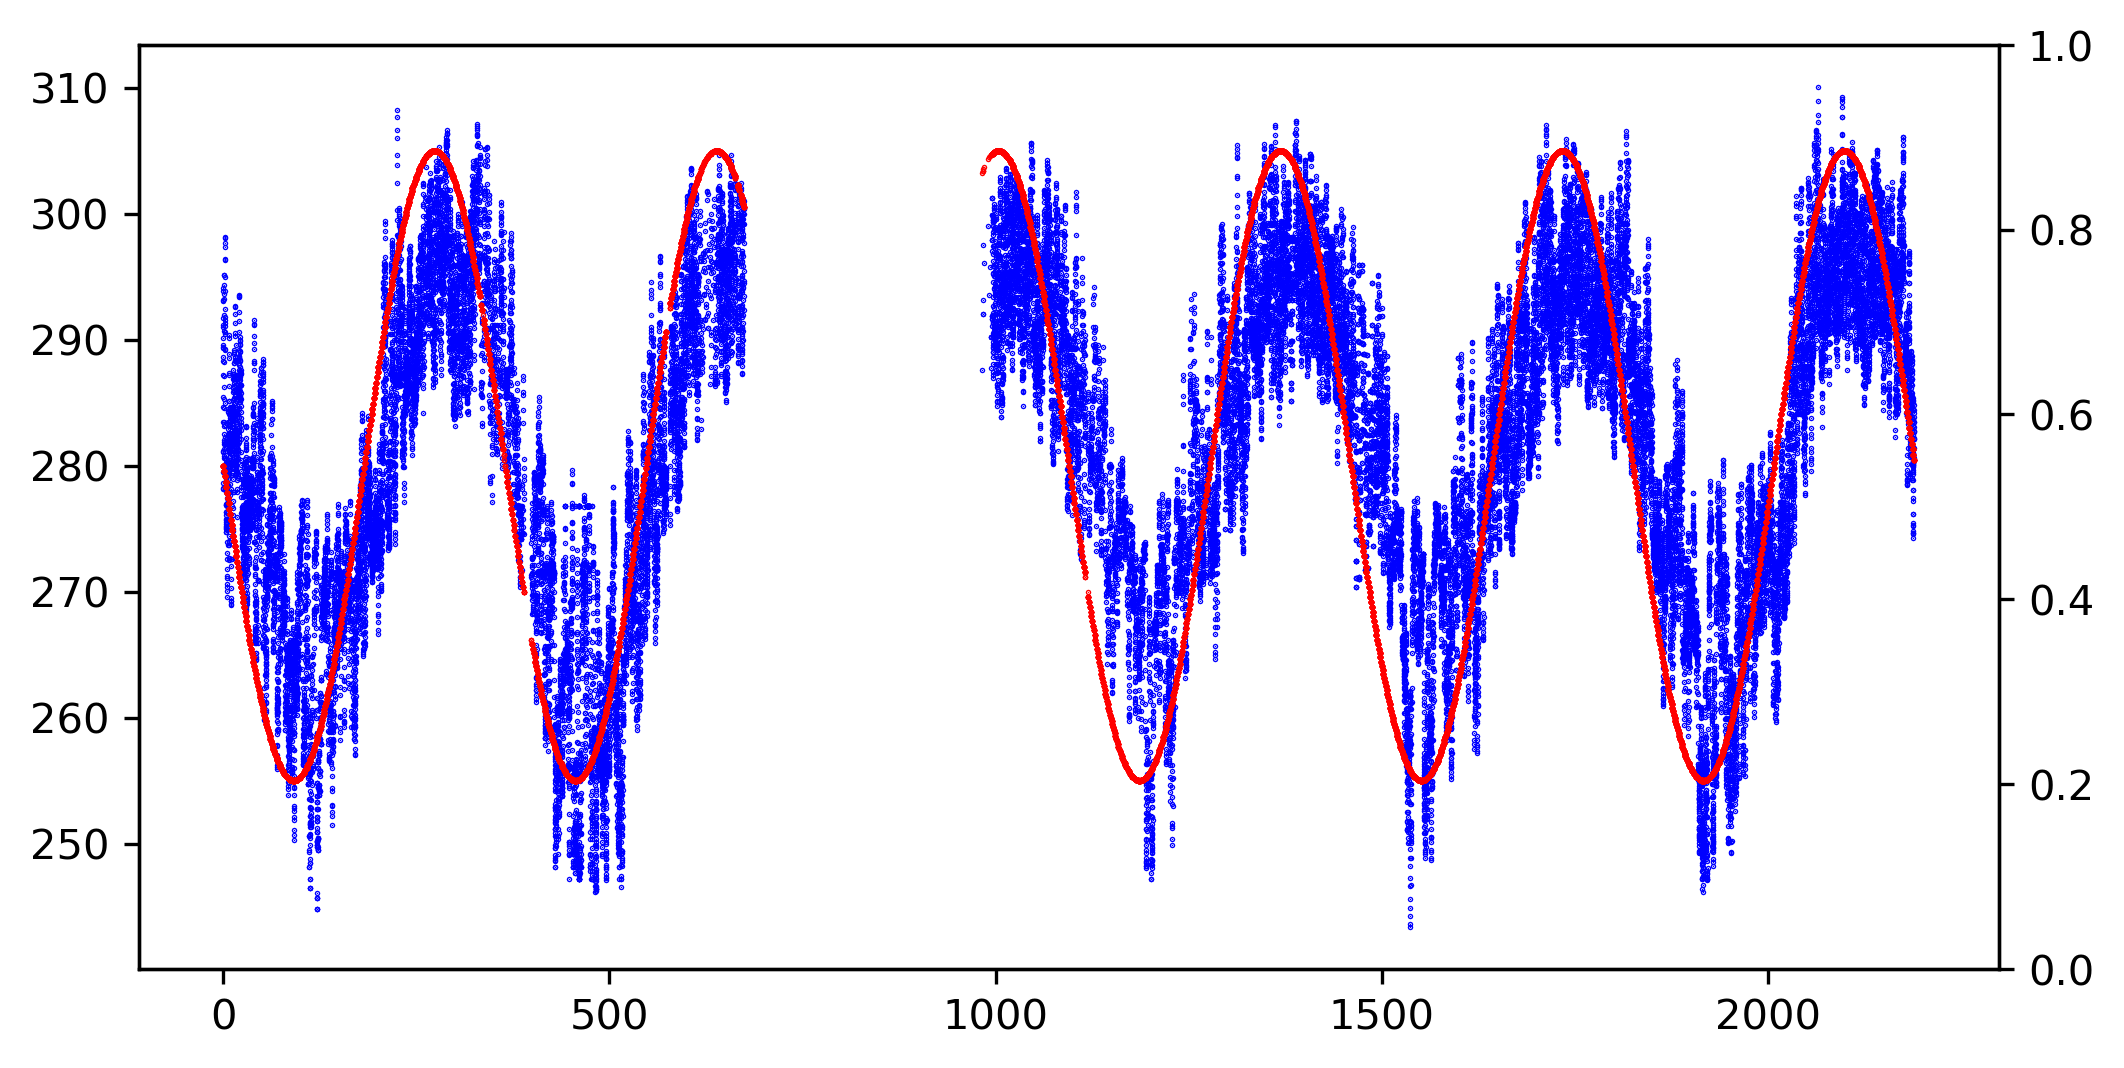

In [119]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

N=dftemp.shape[0]
beta0=280
beta1=-25.
beta2=0.
fig,ax1=plt.subplots()
ax1.scatter(dftemp[:,0], dftemp[:,3],color="blue",s=.1)
ax2 = ax1.twinx() # create another axes object sharing a common x-axis
#ax2.scatter(dftemp[:,0],3*dftemp[:,1]+5*dftemp[:,2], color="red",s=.1)
pred=beta0+beta1*dftemp[:,1]+beta2*dftemp[:,2]
ax1.scatter(dftemp[:,0],pred, color="red",s=.1)
fig.set_size_inches(8,4)
fig.set_dpi(300)
plt.show()


**Prepare the data**

Here we prepare the data for linear regression with the desired predictor columns in a matrix X and response in Y.

In [120]:
X=dftemp[:,1:3] # col1 = sin column col2 = cos column
Y=dftemp[:,3]

In [121]:
X.shape

(40571, 2)

Now we run the regression.

In [122]:
from sklearn.linear_model import LinearRegression

reg= LinearRegression().fit(X,Y)
print(reg.coef_)
print(reg.intercept_) # beta0
Ypred=reg.predict(X)

[-15.19888847   5.21262202]
280.7965712399508


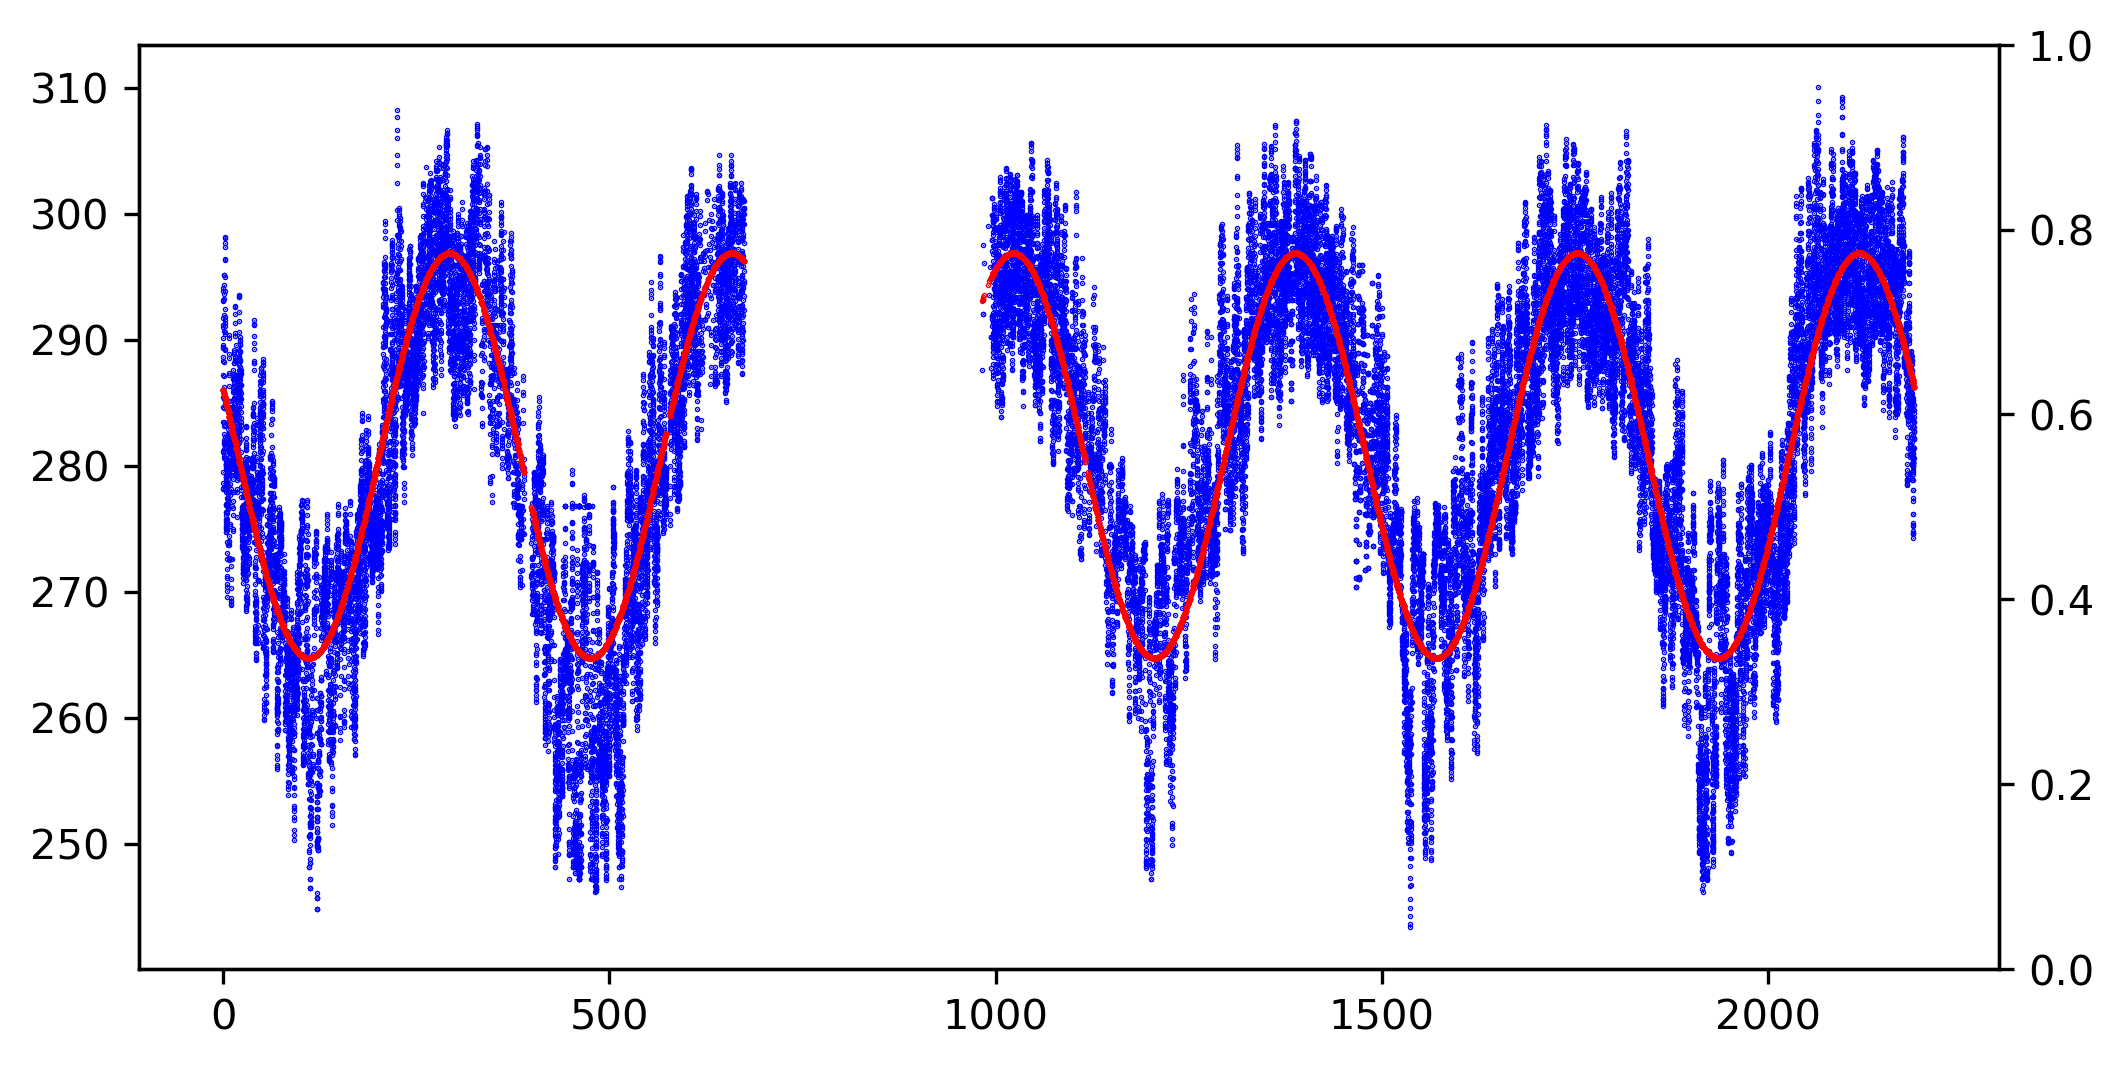

In [123]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

N=dftemp.shape[0]
beta0=reg.intercept_
beta1=reg.coef_[0]
beta2=reg.coef_[1]
fig,ax1=plt.subplots()
ax1.scatter(dftemp[:,0], dftemp[:,3],color="blue",s=.1)
ax2 = ax1.twinx() # create another axes object sharing a common x-axis
#ax2.scatter(dftemp[:,0],3*dftemp[:,1]+5*dftemp[:,2], color="red",s=.1)
ax1.scatter(dftemp[:,0],beta0+beta1*dftemp[:,1]+beta2*dftemp[:,2], color="red",s=.1)
fig.set_size_inches(8,4)
fig.set_dpi(300)
plt.show()


In [124]:
df.to_csv("TRAFFIC_VOLUME2.csv",index=False)